In [1]:
import os
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data.sampler import Sampler

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import random



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib
import datetime as dt
import glob
import bisect
import zipfile
import importlib

from Data_loader import Prc_norm, Thermo_norm, LoadTraining, Normalize, Custom_Sampler

Get precip. normalizer

In [22]:
IMERG_ERA5_PATH='/neelin2020/ML_input/imerg-era5/ocn/'
PRC_PATH=IMERG_ERA5_PATH+'prc_ocn/prc_oceans_2015_01_01.npy'
imerg_prc=Prc_norm(PRC_PATH)
imerg_prc.compute_norm()

In [49]:
HBL_PATH=IMERG_ERA5_PATH+'hbl_ocn/hbl_oceans_2015_01_01.npy'
HLFT_PATH=IMERG_ERA5_PATH+'hlft_ocn/hlft_oceans_2015_01_01.npy'
HSAT_LFT_PATH=IMERG_ERA5_PATH+'hsat_lft_ocn/hsat_lft_oceans_2015_01_01.npy'
era5_thermo=Thermo_norm(HBL_PATH,HLFT_PATH,HSAT_LFT_PATH)
era5_thermo.compute_norm()

In [4]:
import Vae_model 
importlib.reload(Vae_model)


<module 'VAE_models_CVAE_one_endec' from '/home/fiaz/ML/vae/Exploring_latents/VAE_models_CVAE_one_endec.py'>

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
LATENT_DIMS=1
INPUT_DIMS=3
NN_DIMS_ENC=12
NN_DIMS_DEC=12

model=Vae_model.CVAE_ORG_mod(LATENT_DIMS,INPUT_DIMS,
                                             NN_DIMS_ENC,NN_DIMS_DEC).to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.0001
                             ,weight_decay=1e-2)

In [10]:
dst='/home/fiaz/ML/vae/models/cvae_imerg_era5_gamma_gauss_alpha_w=0.75_50_epochs.pth'
# dst='/home/fiaz/ML/vae/models/cvae_gamma_gauss_alpha_w=0.25_11_epochs.pth'
# dst='/home/fiaz/ML/vae/models/cvae_gamma_gauss_alpha_w=0.75_50_epochs.pth'

model.load_state_dict(torch.load(dst))


<All keys matched successfully>

In [11]:
pcp_bins=2**(np.arange(-2.,8.125,0.125))
pcp_bins=np.insert(pcp_bins,0,1e-3)
pcp_bins=np.insert(pcp_bins,0,0)

pcp_bin_center=(pcp_bins[1:]+pcp_bins[:-1])*0.5
dx=np.diff(pcp_bins)

In [32]:
import matplotlib
colors_norm1 = matplotlib.colors.Normalize(vmin=-2, vmax=2.)
cmap = plt.get_cmap('YlOrRd')
col = matplotlib.cm.ScalarMappable(norm=colors_norm1, cmap=cmap)

col_r = matplotlib.cm.ScalarMappable(norm=colors_norm1, 
                                   cmap=plt.get_cmap('YlOrRd_r'))


colors_norm = matplotlib.colors.Normalize(vmin=-4, vmax=4.)
colz = matplotlib.cm.ScalarMappable(norm=colors_norm, cmap=plt.get_cmap('YlOrRd_r'))

### Precip. as a function of therm for fixed z

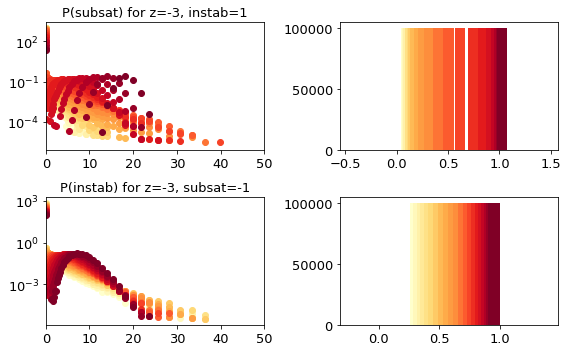

In [38]:
syn_size=1_000_00
z=torch.normal(mean=0.,std=1.,
                            size=(syn_size,LATENT_DIMS))

prc_cond=torch.ones([syn_size,1])

fig,axx=plt.subplots(2,2,figsize=(8.,5.))

for i in np.arange(-2,2.1,.1)[::-2]: 
    z[:]=-3.0

    input_tensor=torch.ones([syn_size,2])
    input_tensor[:,0]=1.0
    input_tensor[:,1]=i
    
    
    log_alpha,log_mu, prob,_=model.decoder(z,input_tensor,
                                             prc_cond)
    
    m1=torch.distributions.Gamma(log_alpha.exp(),
                                 log_alpha.exp()/log_mu.exp())
    
    m2=torch.distributions.Bernoulli(prob)

    prc_array= (m2.sample()*m1.sample()*imerg_prc.precipitating_std).numpy().squeeze()
    
    prc_hist=np.histogram(prc_array,bins=pcp_bins)[0]
    prc_hist=prc_hist/(dx*prc_hist.sum())
    
    axx[0,0].scatter(pcp_bin_center,prc_hist,color=col_r.to_rgba(i))
    axx[0,1].hist(prob.detach().numpy().squeeze(),color=col_r.to_rgba(i))
    
    
for i in np.arange(-2,2.2,.2): 
    z[:]=-3.0

    input_tensor=torch.ones([syn_size,2])
    input_tensor[:,0]=i
    input_tensor[:,1]=-1.0
    
    
    log_alpha,log_mu, prob,_=model.decoder(z,input_tensor,
                                             prc_cond)
    
    m1=torch.distributions.Gamma(log_alpha.exp(),
                                 log_alpha.exp()/log_mu.exp())
    
    m2=torch.distributions.Bernoulli(prob)

    prc_array= (m2.sample()*m1.sample()*imerg_prc.precipitating_std).numpy().squeeze()
    
    prc_hist=np.histogram(prc_array,bins=pcp_bins)[0]
    prc_hist=prc_hist/(dx*prc_hist.sum())
    
    axx[1,0].scatter(pcp_bin_center,prc_hist,color=col.to_rgba(i))
    axx[1,1].hist(prob.detach().numpy().squeeze(),color=col.to_rgba(i))
    
    
axx[0,0].set_yscale('log')
axx[1,0].set_yscale('log')
axx[0,0].set_xlim(0,50)
axx[1,0].set_xlim(0,50)

axx[0,0].set_title('P(subsat) for z=-3, instab=1',fontsize=13)
axx[1,0].set_title('P(instab) for z=-3, subsat=-1',fontsize=13)


for ax in axx[0]:
    ax.tick_params(which='both',labelsize=13)

for ax in axx[1]:
    ax.tick_params(which='both',labelsize=13)

# axx[0,1].set_xlabel('Shape',fontsize=13)
# axx[1,1].set_xlabel('Scale',fontsize=13)
    
plt.tight_layout()

### Precip. as a function of z for fixed thermo 

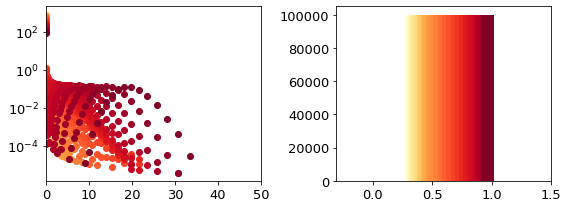

In [48]:
syn_size=1_000_00
z=torch.normal(mean=0.,std=1.,
                            size=(syn_size,LATENT_DIMS))

prc_cond=torch.ones([syn_size,1])

fig,axx=plt.subplots(1,2,figsize=(8.,3.))

for i in np.arange(-4,4.25,.25)[::-1]: 
    z[:]=i

    input_tensor=torch.ones([syn_size,2])
    input_tensor[:,0]=1.5
    input_tensor[:,1]=-1.0
    
    
    log_alpha,log_mu, prob,_=model.decoder(z,input_tensor,
                                             prc_cond)
    
    m1=torch.distributions.Gamma(log_alpha.exp(),
                                 log_alpha.exp()/log_mu.exp())
    
    m2=torch.distributions.Bernoulli(prob)

    prc_array= (m2.sample()*m1.sample()*imerg_prc.precipitating_std).numpy().squeeze()
    
    prc_hist=np.histogram(prc_array,bins=pcp_bins)[0]
    prc_hist=prc_hist/(dx*prc_hist.sum())
    
    axx[0].scatter(pcp_bin_center,prc_hist,color=colz.to_rgba(i))
    axx[1].hist(prob.detach().numpy().squeeze(),color=colz.to_rgba(i))

axx[0].set_yscale('log')
axx[0].set_xlim(0,50)
for ax in axx:
    ax.tick_params(which='both',labelsize=13)
plt.tight_layout()

In [52]:
era5_thermo.instab_std

7.434127014478601

In [70]:
instab_bins=np.arange(-28,18,2)
subsat_bins=np.arange(-2,24,1)

prc_instab_cond_mean=np.zeros((instab_bins.size))
prc_subsat_cond_mean=np.zeros((subsat_bins.size))

prc_2D_cond_sum=np.zeros((instab_bins.size,
                            subsat_bins.size))

prc_2D_cond_counts=np.zeros((instab_bins.size,
                            subsat_bins.size))

In [72]:
syn_size=1_000_00
z=torch.normal(mean=0.,std=1.,
                            size=(syn_size,LATENT_DIMS))

prc_cond=torch.ones([syn_size,1])


for n,i in enumerate(instab_bins):
    for m,j in enumerate(subsat_bins):
        
        input_tensor=torch.ones([syn_size,2])
        input_tensor[:,0]=(i-era5_thermo.instab_mean)/era5_thermo.instab_std
        input_tensor[:,1]=(j-era5_thermo.subsat_mean)/era5_thermo.subsat_std

        log_alpha,log_mu, prob,_=model.decoder(z,input_tensor,
                                                 prc_cond)
        m1=torch.distributions.Gamma(log_alpha.exp(),
                                 log_alpha.exp()/log_mu.exp())    
        m2=torch.distributions.Bernoulli(prob)

        prc_array= (m2.sample()*m1.sample()*imerg_prc.precipitating_std).numpy().squeeze()

        
        prc_2D_cond_mean[n,m]=prc_array.mean()
        
#         prc_hist=np.histogram(prc_array,bins=pcp_bins)[0]
#         prc_hist=prc_hist/(dx*prc_hist.sum())

#         prc_lrh_jpdf[n,:]=np.histogram(prc_array,bins=pcp_bins)[0]

#         axx[0,0].scatter(pcp_bin_center,prc_hist,color=col.to_rgba(i))
#         axx[0,1].scatter(i,prc_array.mean(),color=col.to_rgba(i))
#         axx[1,0].scatter(i,prc_array[prc_array>0].size/prc_array.size,color=col.to_rgba(i))
#         axx[1,1].scatter(i,prc_array.var(),color=col.to_rgba(i))

    


-28
-26
-24
-22
-20
-18
-16
-14
-12
-10
-8
-6
-4
-2
0
2
4
6
8
10
12
14
16


### Use IMERG data to plot obs. comparision 

In [104]:
import imerge_obs_comp 
importlib.reload(imerge_obs_comp)
from imerge_obs_comp import Imerg_era5_binning


DATE_STR=dt.datetime(2015,1,1).strftime('%Y_%m_%d')

IMERG_PATH='/neelin2020/ML_input/imerg-era5/ocn/prc_ocn/prc_oceans_{}.npy'.format(DATE_STR)
HBL_PATH='/neelin2020/ML_input/imerg-era5/ocn/hbl_ocn/hbl_oceans_{}.npy'.format(DATE_STR)
HLFT_PATH='/neelin2020/ML_input/imerg-era5/ocn/hlft_ocn/hlft_oceans_{}.npy'.format(DATE_STR)
HLFT_SAT_PATH='/neelin2020/ML_input/imerg-era5/ocn/hsat_lft_ocn/hsat_lft_oceans_{}.npy'.format(DATE_STR)


obj=Imerg_era5_binning(IMERG_PATH,HBL_PATH,HLFT_PATH,HLFT_SAT_PATH,instab_bins,subsat_bins)

In [105]:
obj.load_files_compute_instab_subsat()

In [106]:
prc_imerg_instab_binned,prc_imerg_subsat_binned=obj.bin_imerg_1D()
prc_imerg_instab_sub_binned,prc_instab_subsat_jpdf=obj.bin_imerg_2D()

/home/fiaz/ML/vae/Exploring_latents/imerge_obs_comp.py:36: RuntimeWarning: Mean of empty slice.
  
/home/fiaz/anaconda3/envs/ML/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fiaz/ML/vae/Exploring_latents/imerge_obs_comp.py:52: RuntimeWarning: Mean of empty slice.
  xind=np.int_((x-xbins[0])/dx)


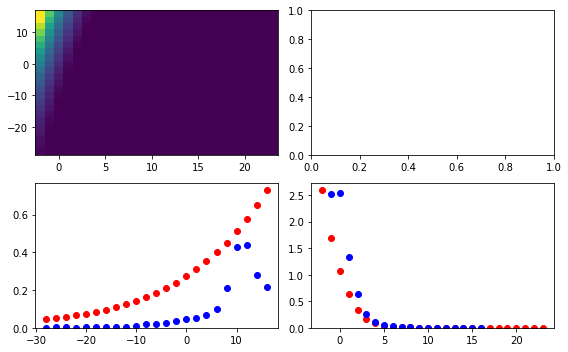

In [110]:
fig,axx=plt.subplots(2,2,figsize=(8.,5.))

# axx[0,0].set_yscale('log')
axx[0,0].pcolormesh(subsat_bins,instab_bins,
                    prc_2D_cond_mean,vmin=0.5,vmax=6)

axx[1,0].scatter(instab_bins,prc_2D_cond_mean.mean(1),color='red')
axx[1,0].scatter(instab_bins,prc_imerg_instab_binned,color='blue')

axx[1,0].set_ylim(bottom=0)

axx[1,1].scatter(subsat_bins,prc_2D_cond_mean.mean(0),color='red')
axx[1,1].scatter(subsat_bins,prc_imerg_subsat_binned,color='blue')

axx[1,1].set_ylim(bottom=0)


# axx[1,0].set_ylim(bottom=0)

plt.tight_layout()

In [77]:
prc_2D_cond_mean.shape,instab_bins.shape

((23, 26), (23,))

In [ ]:
def gamma_ll(alpha,beta,x):
    lgamma_alpha=torch.lgamma(torch.tensor(alpha)).numpy()
    gamma_ll=alpha*np.log(beta)-beta*x-lgamma_alpha+(alpha-1)*np.log(x)
    return gamma_ll

In [ ]:
alpha_array=np.arange(0.1,1e2,5.)
beta_array=np.arange(0.1,1e2,5.)
gamma_ll_array=np.zeros((alpha_array.size,beta_array.size))

for n,i in enumerate(alpha_array):
    for m,j in enumerate(beta_array):
        gamma_ll_array[n,m]=gamma_ll(i,j,i/prc_norm)

In [ ]:
fig,axx=plt.subplots(1,2,figsize=(8,4))
ax=axx[0]
for i in pcp_bin_center:
    ax.scatter(i,gamma_ll(1,1,i/prc_norm),color='black')
    
ax=axx[1]
for i in np.arange(0,1e4,100):
    ax.scatter(i,gamma_ll(i,5,0.5),color='black')

$b=a/x$

(array([4.7108e+04, 3.5399e+04, 1.2487e+04, 3.7150e+03, 9.5300e+02,
        2.5200e+02, 6.8000e+01, 1.3000e+01, 4.0000e+00, 1.0000e+00]),
 array([2.6414171e-03, 1.5861534e+00, 3.1696653e+00, 4.7531772e+00,
        6.3366890e+00, 7.9202013e+00, 9.5037127e+00, 1.1087225e+01,
        1.2670737e+01, 1.4254249e+01, 1.5837761e+01], dtype=float32),
 <BarContainer object of 10 artists>)

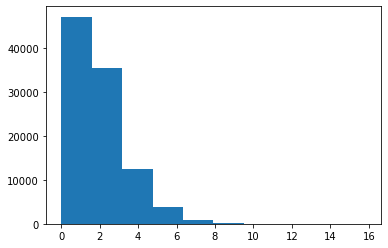

In [224]:
# z=torch.normal(mean=0.,std=0.75,size=(1000_00,)).exp()
z=torch.distributions.Gamma(2,1.).sample((1000_00,))
plt.hist(z.numpy())

In [324]:
n=3
z_sparse=torch.broadcast_to(torch.distributions.Gamma(2,1.).sample((n,)),(50000,n)).flatten()
r=torch.randperm(z_sparse.size()[0])
z_sparse=z_sparse[r]

tensor([0.7872, 2.2446, 0.7872,  ..., 0.7872, 2.2446, 1.6550])

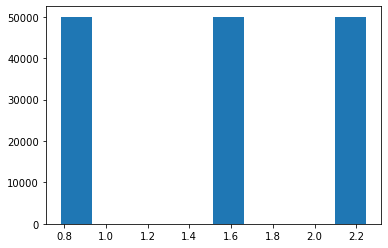

In [325]:
plt.hist(z_sparse.numpy())
z_sparse

$\beta=\frac{\alpha}{\mu}$<br>
$\log \beta=\log \alpha-\log \mu$

In [415]:
loga = torch.tensor([0.], requires_grad=True)
logmu = torch.tensor([0.], requires_grad=False)
lgamma_alpha=torch.lgamma(loga.exp())

x=torch.tensor([1.])

gamma_ll=loga.exp()*(loga-logmu)-(loga.exp()/logmu.exp())*x-lgamma_alpha\
+(loga.exp()-1)*torch.log(x)

(-gamma_ll).backward()


In [427]:
a = torch.tensor([0.], requires_grad=True)
b = torch.tensor([0.], requires_grad=True)
Q = 3*a**3 - b
Q.backward()
a.grad,b.grad

(tensor([0.]), tensor([-1.]))

In [417]:
loga.grad

tensor([-0.5772])

In [330]:
loga = torch.tensor([2.], requires_grad=True)
loglambda = torch.tensor([2.], requires_grad=True)
logb = torch.tensor([2.], requires_grad=True)

logmu = torch.tensor([2.], requires_grad=True)


for n,i in enumerate(z_sparse):
    lgamma_alpha=torch.lgamma(loga.exp())
    
    mse_loss=(logmu.exp()-i)**2
    mse_loss.backward()

#     logb=loglambda.detach().clone()    
#     log_mean=logmu.detach().clone()
    
    gamma_ll=(loga.exp())*logb-(logb.exp())*i-lgamma_alpha+(loga.exp()-1)*torch.log(i)    
#     gamma_ll=loga.exp()*(loga-log_mean)-(loga.exp()/log_mean.exp())*i-lgamma_alpha+(loga.exp()-1)*torch.log(i)
#     exp_ll=loglambda-loglambda.exp()*i

    gamma_ll=-gamma_ll
    gamma_ll.backward()

#     exp_ll=-exp_ll
#     exp_ll.backward()
    
#     weibull_ll=loga+logb+(loga.exp()-1)*(torch.log(x)+logb)-torch.pow(x*logb.exp(),loga.exp())
#     weibull_ll=-weibull_ll
#     weibull_ll.backward()
    if n%1000==0:
        print(n,loga.detach().exp().numpy(),logmu.exp().detach().numpy(),logb.exp().detach().numpy())
        print('gamma nll:',gamma_ll.detach().numpy())
        print('-------------------------------')
#               logb.exp().detach().numpy(),loglambda.exp().detach().numpy())
    lr=1e-3
    loga=torch.tensor([loga-lr*loga.grad],requires_grad=True)
    logb=torch.tensor([logb-lr*logb.grad],requires_grad=True)
#     loglambda=torch.tensor([loglambda-lr*loglambda.grad],requires_grad=True)
#     logmu=torch.tensor([logmu-lr*logmu.grad],requires_grad=True)


0 [7.389056] [7.389056] [7.389056]
gamma nll: [-0.11345685]
-------------------------------
1000 [8.11787] [7.389056] [5.115367]
gamma nll: [1.2401667]
-------------------------------
2000 [7.379624] [7.389056] [4.737237]
gamma nll: [0.44849634]
-------------------------------
3000 [6.8715806] [7.389056] [4.451843]
gamma nll: [0.98795474]
-------------------------------
4000 [6.746796] [7.389056] [4.123587]
gamma nll: [1.1610007]
-------------------------------
5000 [6.1197014] [7.389056] [4.213641]
gamma nll: [1.5093222]
-------------------------------
6000 [6.208049] [7.389056] [3.958219]
gamma nll: [0.53239036]
-------------------------------
7000 [5.9895716] [7.389056] [3.9606526]
gamma nll: [0.5667772]
-------------------------------
8000 [5.941085] [7.389056] [3.8989718]
gamma nll: [0.56669235]
-------------------------------
9000 [6.1762166] [7.389056] [3.7273998]
gamma nll: [0.5258951]
-------------------------------
10000 [6.07699] [7.389056] [3.7518902]
gamma nll: [1.200573]


87000 [5.9057198] [7.389056] [3.7444017]
gamma nll: [0.5558622]
-------------------------------
88000 [5.8863506] [7.389056] [3.7026424]
gamma nll: [0.9731431]
-------------------------------
89000 [5.902298] [7.389056] [3.697282]
gamma nll: [0.9873133]
-------------------------------
90000 [5.85083] [7.389056] [3.7037218]
gamma nll: [1.265598]
-------------------------------
91000 [5.623888] [7.389056] [3.8201027]
gamma nll: [0.7349032]
-------------------------------
92000 [5.9961977] [7.389056] [3.6372085]
gamma nll: [0.541132]
-------------------------------
93000 [5.7376842] [7.389056] [3.7946672]
gamma nll: [0.8152834]
-------------------------------
94000 [5.814558] [7.389056] [3.7829957]
gamma nll: [0.86785126]
-------------------------------
95000 [5.829826] [7.389056] [3.8164918]
gamma nll: [0.5747957]
-------------------------------
96000 [5.834756] [7.389056] [3.7137766]
gamma nll: [0.5631566]
-------------------------------
97000 [5.6914682] [7.389056] [3.732318]
gamma nll

(2.3105178, array(1.9985087, dtype=float32), array([7.389056], dtype=float32))

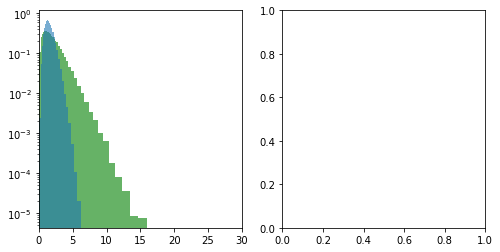

In [332]:
import torch

m1=torch.distributions.Gamma(loga.exp(),logb.exp())
# m1=torch.distributions.Gamma(loga.exp(),
#                              loga.exp()/logmu.exp())
prc_array1= (m1.sample((100_000,))).numpy().squeeze()

# m2=torch.distributions.Gamma(loga.exp(),
#                              loglambda.exp())
# prc_array2= (m2.sample((100_000,))).numpy().squeeze()


fig,axx=plt.subplots(1,2,figsize=(8,4))

ax=axx[0]
# ax.vlines(x.detach().numpy(),1e-2,1e1,
#           linestyle='--')
ax.set_yscale('log')
# ax.set_xlim(left=0,right=10.) 
# ax.set_ylim(1e-2,5e1)

ax.hist(z.numpy(),bins=pcp_bins,alpha=0.6,
        histtype='stepfilled',density=True,color='green')

ax.hist(prc_array1,bins=pcp_bins,alpha=0.6,
        histtype='stepfilled',density=True)

# ax.hist(prc_array2,bins=pcp_bins,alpha=0.6,
#         histtype='stepfilled',density=True)

ax.set_xlim(left=0,right=30)

prc_array.mean(),z.mean().numpy(),logmu.exp().detach().numpy()


When following gradient descent, the gamma log-likelihood update tends to give large $\alpha$ values and small scales. The likelihood is maximized at the smallest possible scale.

In [ ]:
from mpl_toolkits.mplot3d import axes3d
ax = plt.figure().add_subplot(projection='3d')
ax.contourf3D(alpha_array, beta_array, 
             gamma_ll_array, cmap=plt.get_cmap('coolwarm'))  # Plot contour curves


In [ ]:
gamma_ll_array.min()

Visualize the learnt function

In [ ]:
zarray=np.arange(-4,4.05,0.05)
alpha_func=np.zeros((lrh_array.size,zarray.size))
scale_func=np.zeros((lrh_array.size,zarray.size))
prob_func=np.zeros((lrh_array.size,zarray.size))


for m,ir in enumerate(lrh_array):
    for n,iz in enumerate(zarray):
        log_alpha,log_beta, prob,_=model.decoder(torch.tensor([float(iz)]).unsqueeze(1),
                                                 torch.tensor([float(ir)]).unsqueeze(1),prc_cond)
        alpha_func[m,n]=log_alpha.exp().detach().numpy()
        scale_func[m,n]=1./log_beta.exp().detach().numpy()
        prob_func[m,n]=prob.detach().numpy()

In [ ]:
fig,axx=plt.subplots(1,3,figsize=(8,3))

ax=axx[0]
ax.pcolormesh(lrh_array,zarray,alpha_func.T)

ax=axx[1]
ax.pcolormesh(lrh_array,zarray,scale_func.T)

ax=axx[2]
ax.pcolormesh(lrh_array,zarray,prob_func.T,
              vmin=0,vmax=0.8)

plt.tight_layout()

In [ ]:
print(alpha_func.max(),alpha_func.min())
scale_func.max(),scale_func.min()

In [ ]:
plt.pcolormesh(lrh_array,pcp_bin_center,
               np.log(prc_lrh_jpdf).T,cmap=plt.get_cmap('YlOrRd'))
plt.ylim(top=50,bottom=-1)

In [ ]:
z[:]=3.

crh_cond=torch.ones([syn_size,1])
crh_cond[:]=0.8

log_alpha, log_beta, prob,_=model.decoder(z,crh_cond,
                                        prc_cond)
m1=torch.distributions.Gamma(log_alpha.exp(),log_beta.exp())
m2=torch.distributions.Bernoulli(prob)

In [ ]:
m1.sample()*m2.sample()